In [1]:
#Capstone Project
#Luke Sullivan

In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import levene
from statsmodels.stats.multitest import multipletests
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from imblearn.over_sampling import SMOTE

In [3]:
#Seeded Random with Luke Sullivan's NYU N#: N15924374
np.random.seed(15924374)

In [4]:
#data
num_data = pd.read_csv('rmpCapstoneNum.csv', header=None)
qual_data = pd.read_csv('rmpCapstoneQual.csv', header=None)
tags_data = pd.read_csv('rmpCapstoneTags.csv', header=None)

# Data Cleaning

## Data Cleaning [num_data]

In [5]:
num_data.columns = ['Avg Rating', 'Avg Difficulty', 'Count', 'Pepper', 'Retake', 'Online Count', 'Male', 'Female']

In [6]:
num_data.head(5)

,Avg Rating,Avg Difficulty,Count,Pepper,Retake,Online Count,Male,Female
0,5.0,1.5,2.0,0.0,NaN,0.0,0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,3.2,3.0,4.0,0.0,NaN,0.0,1,0
3,3.6,3.5,10.0,1.0,NaN,0.0,0,0
4,1.0,5.0,1.0,0.0,NaN,0.0,0,0


In [7]:
num_data.isnull().sum()

Avg Rating        19889
Avg Difficulty    19889
Count             19889
Pepper            19889
Retake            77733
Online Count      19889
Male                  0
Female                0
dtype: int64

In [8]:
num_data.shape

(89893, 8)

In [9]:
#19889 professor rows have missing data. With no data to impute or analyze, removing the rows entirely seems like the best choice
#to avoid bias and preserve the datasets integrity. Imputing these rows with complete missing data would drive bias and therefore create
#an unclean dataset to work in.
#stats_df = num_data.dropna(subset=['Avg Rating', 'Avg Difficulty'], how='all')
stats_df = num_data
print(stats_df.shape)
stats_df.head()

(89893, 8)


,Avg Rating,Avg Difficulty,Count,Pepper,Retake,Online Count,Male,Female
0,5.0,1.5,2.0,0.0,NaN,0.0,0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,3.2,3.0,4.0,0.0,NaN,0.0,1,0
3,3.6,3.5,10.0,1.0,NaN,0.0,0,0
4,1.0,5.0,1.0,0.0,NaN,0.0,0,0


In [10]:
numcount = num_data['Count'].value_counts()
print(numcount.head(40))

Count
1.0     17633
2.0     11843
3.0      8577
4.0      6583
5.0      4791
6.0      3736
7.0      2846
8.0      2267
9.0      1887
10.0     1495
11.0     1144
12.0      966
13.0      831
14.0      726
15.0      534
16.0      523
17.0      402
18.0      374
19.0      298
20.0      281
21.0      228
22.0      210
23.0      194
24.0      134
25.0      126
27.0      113
26.0      110
28.0       81
29.0       79
30.0       76
31.0       71
32.0       70
33.0       59
35.0       52
36.0       49
38.0       41
37.0       36
34.0       35
39.0       31
40.0       27
Name: count, dtype: int64


In [11]:
print('Retake null rows:', stats_df['Retake'].isnull().sum())

Retake null rows: 77733


In [12]:
stats_df = stats_df.drop('Retake', axis=1)

## Data Cleaning [qual_data]

In [13]:
qual_data.columns = ['Major', 'University', 'State']

In [14]:
qual_data.head()

,Major,University,State
0,Criminal Justice,George Mason University,VA
1,NaN,NaN,NaN
2,English,Alabama State University,AL
3,English,University of Kentucky,KY
4,English,Keiser University,FL


In [15]:
qual_data.isnull().sum()

Major         19889
University    19889
State         19889
dtype: int64

In [16]:
qual_data.shape

(89893, 3)

In [17]:
### 19889 is the same missing rows in the other dataset, meaning the same professor data is not available. Therefore dropping the rows.
#qual_df = qual_data.dropna()
qual_df = qual_data
#print(qual_df.shape)
qual_df.head()

,Major,University,State
0,Criminal Justice,George Mason University,VA
1,NaN,NaN,NaN
2,English,Alabama State University,AL
3,English,University of Kentucky,KY
4,English,Keiser University,FL


## Data Cleaning [tags_data]

In [18]:
tags = [
    "Tough grader",
    "Good feedback",
    "Respected",
    "Lots to read",
    "Participation matters",
    "Don’t skip class or you will not pass",
    "Lots of homework",
    "Inspirational",
    "Pop quizzes!",
    "Accessible",
    "So many papers",
    "Clear grading",
    "Hilarious",
    "Test heavy",
    "Graded by few things",
    "Amazing lectures",
    "Caring",
    "Extra credit",
    "Group projects",
    "Lecture heavy"
]

In [19]:
tags_data.columns = tags

In [20]:
tags_data.head()

,Tough grader,Good feedback,Respected,Lots to read,Participation matters,Don’t skip class or you will not pass,Lots of homework,Inspirational,Pop quizzes!,Accessible,So many papers,Clear grading,Hilarious,Test heavy,Graded by few things,Amazing lectures,Caring,Extra credit,Group projects,Lecture heavy
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1,2,1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,3,0,0,2,4,2,1,0,0,0,2,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
tags_data.isnull().sum()

Tough grader                             0
Good feedback                            0
Respected                                0
Lots to read                             0
Participation matters                    0
Don’t skip class or you will not pass    0
Lots of homework                         0
Inspirational                            0
Pop quizzes!                             0
Accessible                               0
So many papers                           0
Clear grading                            0
Hilarious                                0
Test heavy                               0
Graded by few things                     0
Amazing lectures                         0
Caring                                   0
Extra credit                             0
Group projects                           0
Lecture heavy                            0
dtype: int64

In [22]:
tags_data.shape

(89893, 20)

In [23]:
count_all_zero_rows = (tags_data.eq(0).all(axis=1)).sum()

print(f"Number of rows where all columns are 0: {count_all_zero_rows}")

Number of rows where all columns are 0: 25348


In [24]:
#all_zero_rows = tags_data[(tags_data == 0).all(axis=1)]
#rows_to_drop = all_zero_rows.index[:19889]

tags_df = tags_data

###Dropped 19889 rows that contain all 0's to account for the dropped 19889 professors from the other CSV data.

In [25]:
tags_df.shape

(89893, 20)

In [26]:
tags_df.head()

,Tough grader,Good feedback,Respected,Lots to read,Participation matters,Don’t skip class or you will not pass,Lots of homework,Inspirational,Pop quizzes!,Accessible,So many papers,Clear grading,Hilarious,Test heavy,Graded by few things,Amazing lectures,Caring,Extra credit,Group projects,Lecture heavy
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1,2,1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,3,0,0,2,4,2,1,0,0,0,2,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
normal_tags_df = tags_df.div(tags_df.sum(axis=1), axis=0)

#Without normalization, professors with more ratings would disproportionately influence any analysis or comparisons, as their 
#tag counts would naturally be higher due to the larger sample size. Row-wise normalization addresses this by scaling each 
#professor's tag counts relative to their total ratings. This ensures that professors with high or low rating volumes are treated 
#equally when analyzing the distribution of tags.

In [28]:
normal_tags_df.head()

,Tough grader,Good feedback,Respected,Lots to read,Participation matters,Don’t skip class or you will not pass,Lots of homework,Inspirational,Pop quizzes!,Accessible,So many papers,Clear grading,Hilarious,Test heavy,Graded by few things,Amazing lectures,Caring,Extra credit,Group projects,Lecture heavy
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.5
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.166667,0.083333,0.166667,0.083333,0.000000,0.333333,0.166667,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.272727,0.136364,0.000000,0.000000,0.090909,0.181818,0.090909,0.045455,0.0,0.0,0.0,0.090909,0.045455,0.0,0.0,0.0,0.0,0.0,0.045455,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
normal_tags_df.isnull().sum()

Tough grader                             25348
Good feedback                            25348
Respected                                25348
Lots to read                             25348
Participation matters                    25348
Don’t skip class or you will not pass    25348
Lots of homework                         25348
Inspirational                            25348
Pop quizzes!                             25348
Accessible                               25348
So many papers                           25348
Clear grading                            25348
Hilarious                                25348
Test heavy                               25348
Graded by few things                     25348
Amazing lectures                         25348
Caring                                   25348
Extra credit                             25348
Group projects                           25348
Lecture heavy                            25348
dtype: int64

## Merging Datasets into 1 Dataframe

In [30]:
rmpStats = stats_df.join(qual_df)
rmpStats = rmpStats.join(normal_tags_df)
rmpStats.head()

,Avg Rating,Avg Difficulty,Count,Pepper,Online Count,Male,Female,Major,University,State,...,So many papers,Clear grading,Hilarious,Test heavy,Graded by few things,Amazing lectures,Caring,Extra credit,Group projects,Lecture heavy
0,5.0,1.5,2.0,0.0,0.0,0,1,Criminal Justice,George Mason University,VA,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.5
1,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.2,3.0,4.0,0.0,0.0,1,0,English,Alabama State University,AL,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,3.6,3.5,10.0,1.0,0.0,0,0,English,University of Kentucky,KY,...,0.0,0.090909,0.045455,0.0,0.0,0.0,0.0,0.0,0.045455,0.0
4,1.0,5.0,1.0,0.0,0.0,0,0,English,Keiser University,FL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
rmpStats.isnull().sum()

Avg Rating                               19889
Avg Difficulty                           19889
Count                                    19889
Pepper                                   19889
Online Count                             19889
Male                                         0
Female                                       0
Major                                    19889
University                               19889
State                                    19889
Tough grader                             25348
Good feedback                            25348
Respected                                25348
Lots to read                             25348
Participation matters                    25348
Don’t skip class or you will not pass    25348
Lots of homework                         25348
Inspirational                            25348
Pop quizzes!                             25348
Accessible                               25348
So many papers                           25348
Clear grading

In [32]:
print("old shape:", rmpStats.shape)
rmpStats = rmpStats.dropna(subset=['Avg Rating'], how='all')
print("new shape:", rmpStats.shape)

old shape: (89893, 30)
new shape: (70004, 30)


In [33]:
rmpStats.isnull().sum()

Avg Rating                                  0
Avg Difficulty                              0
Count                                       0
Pepper                                      0
Online Count                                0
Male                                        0
Female                                      0
Major                                       0
University                                  0
State                                       0
Tough grader                             5459
Good feedback                            5459
Respected                                5459
Lots to read                             5459
Participation matters                    5459
Don’t skip class or you will not pass    5459
Lots of homework                         5459
Inspirational                            5459
Pop quizzes!                             5459
Accessible                               5459
So many papers                           5459
Clear grading                     

In [34]:
#The rows where 5459 are NA are rows that contain tags with no values. This would just be 0 in the dataset and
#since the other professor data is present, setting this data to 0 makes the most sense.
exclude_column = 'Retake'
columns_to_fill = rmpStats.columns.difference([exclude_column])
rmpStats[columns_to_fill] = rmpStats[columns_to_fill].fillna(0)

In [35]:
rmpStats.isnull().sum()

Avg Rating                               0
Avg Difficulty                           0
Count                                    0
Pepper                                   0
Online Count                             0
Male                                     0
Female                                   0
Major                                    0
University                               0
State                                    0
Tough grader                             0
Good feedback                            0
Respected                                0
Lots to read                             0
Participation matters                    0
Don’t skip class or you will not pass    0
Lots of homework                         0
Inspirational                            0
Pop quizzes!                             0
Accessible                               0
So many papers                           0
Clear grading                            0
Hilarious                                0
Test heavy 

In [36]:
rmpStats.head(10)

,Avg Rating,Avg Difficulty,Count,Pepper,Online Count,Male,Female,Major,University,State,...,So many papers,Clear grading,Hilarious,Test heavy,Graded by few things,Amazing lectures,Caring,Extra credit,Group projects,Lecture heavy
0,5.0,1.5,2.0,0.0,0.0,0,1,Criminal Justice,George Mason University,VA,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.500000
2,3.2,3.0,4.0,0.0,0.0,1,0,English,Alabama State University,AL,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,3.6,3.5,10.0,1.0,0.0,0,0,English,University of Kentucky,KY,...,0.0,0.090909,0.045455,0.0,0.0,0.0,0.000000,0.0,0.045455,0.000000
4,1.0,5.0,1.0,0.0,0.0,0,0,English,Keiser University,FL,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
5,3.5,3.3,22.0,0.0,7.0,1,0,English,Eastern Florida State College,FL,...,0.0,0.132075,0.056604,0.0,0.0,0.0,0.056604,0.0,0.018868,0.056604
6,2.3,3.5,2.0,0.0,0.0,0,0,Biology,Marquette University,WI,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
7,2.5,3.0,2.0,0.0,0.0,1,1,English,Arkansas State University,AR,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
8,2.6,4.5,4.0,1.0,0.0,0,0,Fine Arts,St. Ambrose University,IA,...,0.0,0.200000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.200000
9,3.0,1.0,1.0,0.0,0.0,0,1,English,Colorado Mesa University,CO,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
10,4.5,3.0,1.0,0.0,0.0,0,1,Biology,Union County College,NJ,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [37]:
rmpStats.duplicated().sum()
duplicate_rows = rmpStats[rmpStats.duplicated()]
print("Duplicate rows based on all columns:\n", duplicate_rows)

Duplicate rows based on all columns:
        Avg Rating  Avg Difficulty  Count  Pepper  Online Count  Male  Female  \
899           5.0             1.0    1.0     0.0           0.0     0       1   
1154          5.0             3.0    1.0     0.0           0.0     0       1   
4065          3.0             4.0    1.0     0.0           0.0     0       1   
13784         4.5             3.0    1.0     0.0           0.0     0       1   
15432         4.5             2.0    1.0     0.0           0.0     0       1   
17012         4.0             4.0    1.0     0.0           0.0     0       1   
17277         3.0             4.0    1.0     0.0           0.0     1       0   
19515         1.0             3.0    1.0     0.0           0.0     1       0   
25025         5.0             1.0    1.0     0.0           0.0     1       0   
31617         2.0             3.0    1.0     0.0           1.0     1       0   
34882         2.0             5.0    1.0     0.0           0.0     0       1   
63

In [38]:
#The 15 duplicates that are in the dataset appear to be all individual professors that have the same statistics,
#therefore it makes sense to leave them in the dataset.

In [39]:
print(rmpStats.columns)

Index(['Avg Rating', 'Avg Difficulty', 'Count', 'Pepper', 'Online Count',
       'Male', 'Female', 'Major', 'University', 'State', 'Tough grader',
       'Good feedback', 'Respected', 'Lots to read', 'Participation matters',
       'Don’t skip class or you will not pass', 'Lots of homework',
       'Inspirational', 'Pop quizzes!', 'Accessible', 'So many papers',
       'Clear grading', 'Hilarious', 'Test heavy', 'Graded by few things',
       'Amazing lectures', 'Caring', 'Extra credit', 'Group projects',
       'Lecture heavy'],
      dtype='object')


## Averages with num of ratings column ('Count')

In [40]:
rmpStats['Weighted Avg Rating'] = rmpStats['Avg Rating'] * rmpStats['Count'] / rmpStats['Count']
rmpStats['Weighted Avg Difficulty'] = rmpStats['Avg Difficulty'] * rmpStats['Count'] / rmpStats['Count']

In [41]:
rmpStats.head()

,Avg Rating,Avg Difficulty,Count,Pepper,Online Count,Male,Female,Major,University,State,...,Hilarious,Test heavy,Graded by few things,Amazing lectures,Caring,Extra credit,Group projects,Lecture heavy,Weighted Avg Rating,Weighted Avg Difficulty
0,5.0,1.5,2.0,0.0,0.0,0,1,Criminal Justice,George Mason University,VA,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.500000,5.0,1.5
2,3.2,3.0,4.0,0.0,0.0,1,0,English,Alabama State University,AL,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,3.2,3.0
3,3.6,3.5,10.0,1.0,0.0,0,0,English,University of Kentucky,KY,...,0.045455,0.0,0.0,0.0,0.000000,0.0,0.045455,0.000000,3.6,3.5
4,1.0,5.0,1.0,0.0,0.0,0,0,English,Keiser University,FL,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.0,5.0
5,3.5,3.3,22.0,0.0,7.0,1,0,English,Eastern Florida State College,FL,...,0.056604,0.0,0.0,0.0,0.056604,0.0,0.018868,0.056604,3.5,3.3


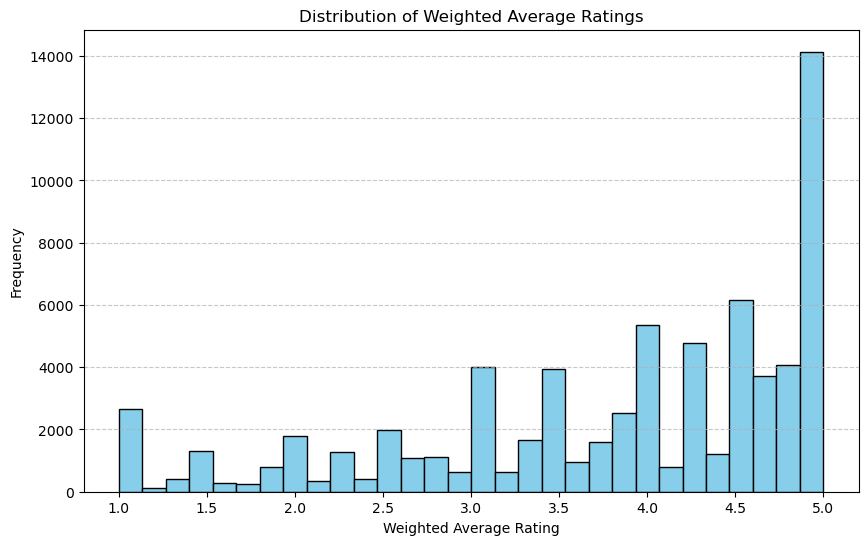

In [42]:
# Plotting the Weighted Average Ratings
plt.figure(figsize=(10, 6))
plt.hist(rmpStats['Weighted Avg Rating'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Weighted Average Ratings')
plt.xlabel('Weighted Average Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [43]:
counts_value_counts = rmpStats['Count'].value_counts()

# Display the counts
print(counts_value_counts.head(40))

Count
1.0     17633
2.0     11843
3.0      8577
4.0      6583
5.0      4791
6.0      3736
7.0      2846
8.0      2267
9.0      1887
10.0     1495
11.0     1144
12.0      966
13.0      831
14.0      726
15.0      534
16.0      523
17.0      402
18.0      374
19.0      298
20.0      281
21.0      228
22.0      210
23.0      194
24.0      134
25.0      126
27.0      113
26.0      110
28.0       81
29.0       79
30.0       76
31.0       71
32.0       70
33.0       59
35.0       52
36.0       49
38.0       41
37.0       36
34.0       35
39.0       31
40.0       27
Name: count, dtype: int64


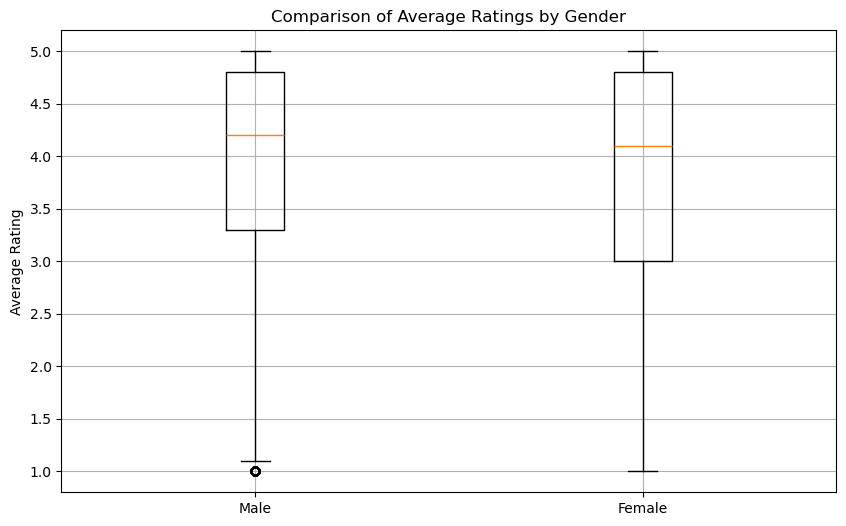

Count male ratings: 29376
Count female ratings: 27139


In [44]:
male_ratings = rmpStats[rmpStats['Male'] == 1]['Avg Rating']
female_ratings = rmpStats[rmpStats['Female'] == 1]['Avg Rating']

plt.figure(figsize=(10, 6))
plt.boxplot([male_ratings, female_ratings], labels=['Male', 'Female'])
plt.title('Comparison of Average Ratings by Gender')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

print("Count male ratings:", len(male_ratings))
print("Count female ratings:", len(female_ratings))

In [45]:
rmpStats.describe()

,Avg Rating,Avg Difficulty,Count,Pepper,Online Count,Male,Female,Tough grader,Good feedback,Respected,...,Hilarious,Test heavy,Graded by few things,Amazing lectures,Caring,Extra credit,Group projects,Lecture heavy,Weighted Avg Rating,Weighted Avg Difficulty
count,70004.000000,70004.000000,70004.000000,70004.000000,70004.000000,70004.000000,70004.000000,70004.000000,70004.000000,70004.000000,...,70004.000000,70004.000000,70004.000000,70004.000000,70004.000000,70004.000000,70004.000000,70004.000000,70004.000000,70004.000000
mean,3.808014,2.864623,5.374721,0.279927,0.315611,0.419633,0.387678,0.080735,0.103860,0.065140,...,0.042816,0.009105,0.011175,0.037374,0.081024,0.034725,0.022148,0.040330,3.808014,2.864623
std,1.126895,0.991064,8.136628,0.448966,1.054728,0.493502,0.487224,0.144487,0.137315,0.110305,...,0.096405,0.039528,0.047703,0.083841,0.121572,0.088457,0.075555,0.099494,1.126895,0.991064
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000
50%,4.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,3.000000
75%,4.800000,3.500000,6.000000,1.000000,0.000000,1.000000,1.000000,0.125000,0.166667,0.100000,...,0.028571,0.000000,0.000000,0.032258,0.133333,0.000000,0.000000,0.016949,4.800000,3.500000
max,5.000000,5.000000,393.000000,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000


In [46]:
other_gender_df = rmpStats[(rmpStats['Male'] == rmpStats['Female'])]
other_gender_df.head(10)

,Avg Rating,Avg Difficulty,Count,Pepper,Online Count,Male,Female,Major,University,State,...,Hilarious,Test heavy,Graded by few things,Amazing lectures,Caring,Extra credit,Group projects,Lecture heavy,Weighted Avg Rating,Weighted Avg Difficulty
3,3.6,3.5,10.0,1.0,0.0,0,0,English,University of Kentucky,KY,...,0.045455,0.000000,0.000000,0.000000,0.0,0.000000,0.045455,0.000000,3.6,3.5
4,1.0,5.0,1.0,0.0,0.0,0,0,English,Keiser University,FL,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,5.0
6,2.3,3.5,2.0,0.0,0.0,0,0,Biology,Marquette University,WI,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.3,3.5
7,2.5,3.0,2.0,0.0,0.0,1,1,English,Arkansas State University,AR,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.5,3.0
8,2.6,4.5,4.0,1.0,0.0,0,0,Fine Arts,St. Ambrose University,IA,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.200000,2.6,4.5
12,2.5,5.0,1.0,0.0,0.0,0,0,Computer Science,University of Mississippi,MS,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.5,5.0
24,3.5,2.0,1.0,0.0,0.0,0,0,Economics,Northern Illinois University,IL,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.5,2.0
26,4.8,2.5,4.0,1.0,0.0,0,0,Biology,Frostburg State University,MD,...,0.000000,0.142857,0.000000,0.285714,0.0,0.142857,0.000000,0.000000,4.8,2.5
31,2.2,4.4,5.0,0.0,0.0,0,0,Mathematics,Victor Valley College,CA,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.285714,2.2,4.4
32,2.5,3.5,2.0,0.0,0.0,0,0,Spanish,Christopher Newport University,VA,...,0.000000,0.000000,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,2.5,3.5


In [47]:
rmpStats = rmpStats[rmpStats['Male'] != rmpStats['Female']]

In [48]:
other_gender_df = rmpStats[(rmpStats['Male'] == rmpStats['Female'])]
print(len(other_gender_df))
#Dropped the rows where gender was 0,0 or 1,1. This ensures that the data is purely male and female representations, based off
#the provided ratings data provided by RMF.

0


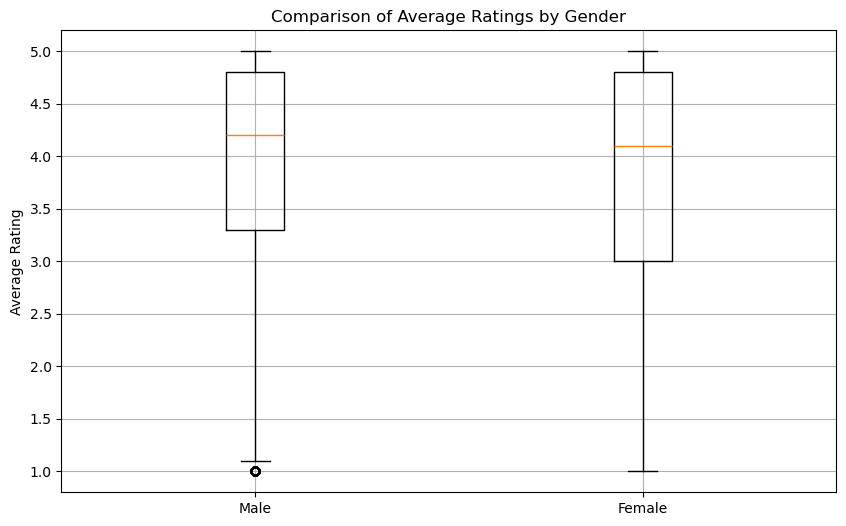

Count male ratings: 27163
Count female ratings: 24926


In [49]:
male_ratings = rmpStats[rmpStats['Male'] == 1]['Avg Rating']
female_ratings = rmpStats[rmpStats['Female'] == 1]['Avg Rating']

plt.figure(figsize=(10, 6))
plt.boxplot([male_ratings, female_ratings], labels=['Male', 'Female'])
plt.title('Comparison of Average Ratings by Gender')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

print("Count male ratings:", len(male_ratings))
print("Count female ratings:", len(female_ratings))

In [50]:
rmpStats.describe()

,Avg Rating,Avg Difficulty,Count,Pepper,Online Count,Male,Female,Tough grader,Good feedback,Respected,...,Hilarious,Test heavy,Graded by few things,Amazing lectures,Caring,Extra credit,Group projects,Lecture heavy,Weighted Avg Rating,Weighted Avg Difficulty
count,52089.000000,52089.000000,52089.000000,52089.000000,52089.000000,52089.000000,52089.000000,52089.000000,52089.000000,52089.000000,...,52089.000000,52089.000000,52089.000000,52089.000000,52089.000000,52089.000000,52089.000000,52089.000000,52089.000000,52089.000000
mean,3.845870,2.846234,5.261495,0.276949,0.325251,0.521473,0.478527,0.078368,0.107325,0.066204,...,0.045416,0.008599,0.010918,0.037590,0.080592,0.033850,0.021338,0.038869,3.845870,2.846234
std,1.115059,0.991337,7.990356,0.447495,1.068762,0.499543,0.499543,0.142434,0.139456,0.112002,...,0.099841,0.038859,0.046944,0.084293,0.121533,0.088022,0.074070,0.098163,1.115059,0.991337
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,3.100000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.100000,2.000000
50%,4.200000,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.047619,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.200000,3.000000
75%,4.800000,3.500000,6.000000,1.000000,0.000000,1.000000,1.000000,0.111111,0.181818,0.105263,...,0.037736,0.000000,0.000000,0.032258,0.133333,0.000000,0.000000,0.000000,4.800000,3.500000
max,5.000000,5.000000,393.000000,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000


In [51]:
#Dropping the rows did not change the data very much, it slightly increased to hte thousandth for the overall dataset.
#Visually, the ratings data did not change much after dropping the data for both male and female ratings seperately.

### Dealing with the average ratings

In [52]:
counts_value_counts = rmpStats['Count'].value_counts()

# Display the counts
print(counts_value_counts.head(40))

Count
1.0     13465
2.0      8898
3.0      6445
4.0      4859
5.0      3538
6.0      2715
7.0      2061
8.0      1640
9.0      1363
10.0     1094
11.0      822
12.0      700
13.0      607
14.0      528
15.0      380
16.0      368
17.0      294
18.0      264
19.0      227
20.0      195
21.0      177
22.0      155
23.0      149
25.0       90
24.0       87
27.0       86
26.0       74
28.0       61
29.0       56
31.0       53
32.0       52
30.0       47
33.0       40
36.0       35
35.0       34
38.0       28
34.0       28
37.0       27
39.0       21
41.0       17
Name: count, dtype: int64


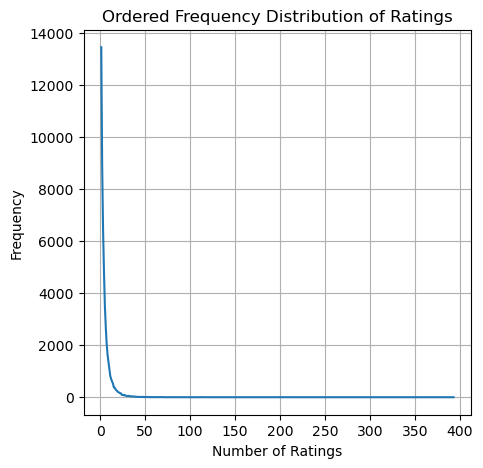

In [53]:
counts_value_counts = rmpStats['Count'].value_counts()

# Reorder counts_value_counts by index (sorted by the 'Count' value)
ordered_counts = counts_value_counts.sort_index()

# Plot the ordered frequency of ratings
plt.figure(figsize=[5, 5])
plt.plot(ordered_counts.index, ordered_counts.values)
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.title('Ordered Frequency Distribution of Ratings')
plt.grid(True)
plt.show()

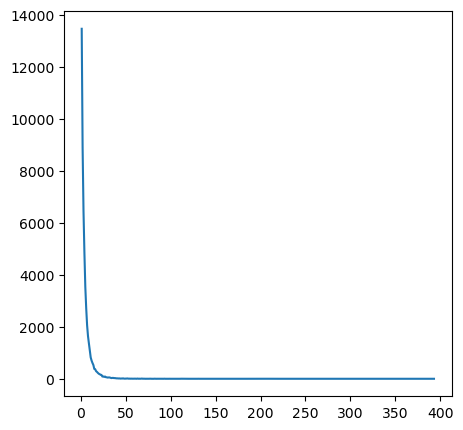

In [54]:
plt.figure(figsize=[5,5])
plt.plot(ordered_counts.index, ordered_counts)
plt.show()

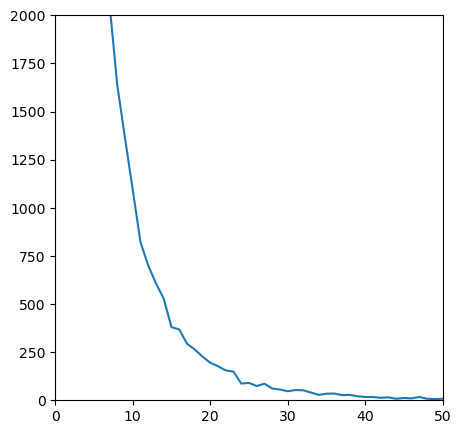

In [55]:
plt.figure(figsize=[5,5])
plt.plot(ordered_counts.index, ordered_counts)
plt.xlim(0, 50)
plt.ylim(0, 2000)
plt.show()

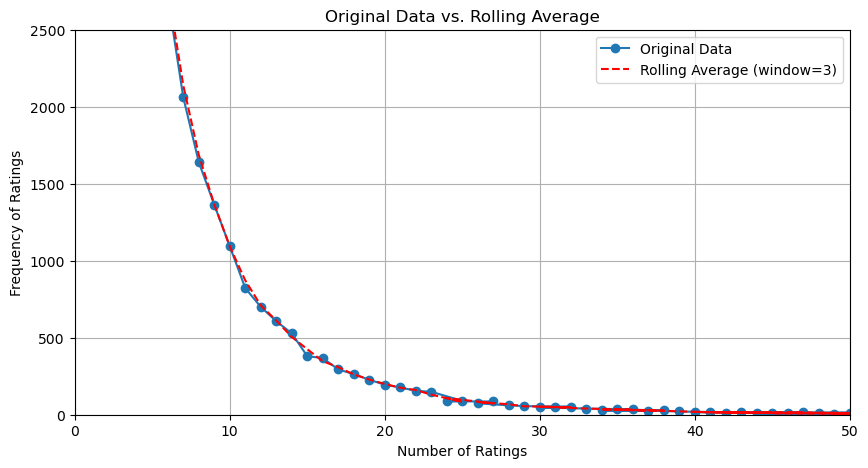

In [56]:
rolling_avg = ordered_counts.rolling(window=3, min_periods=1, center=True).mean()

plt.figure(figsize=(10, 5))
plt.plot(counts_value_counts.index, counts_value_counts, label='Original Data', marker='o')
df_rolling_avg = rolling_avg.reindex(counts_value_counts.index)
plt.plot(df_rolling_avg.index, df_rolling_avg, label='Rolling Average (window=3)', linestyle='--', color='red')
plt.xlim(0, 50)
plt.ylim(0, 2500) 
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency of Ratings')
plt.title('Original Data vs. Rolling Average')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
df_rolling_avg.head()

Count
1.0    11181.500000
2.0     9602.666667
3.0     6734.000000
4.0     4947.333333
5.0     3704.000000
Name: count, dtype: float64

In [58]:
ordered_counts.head()

Count
1.0    13465
2.0     8898
3.0     6445
4.0     4859
5.0     3538
Name: count, dtype: int64

In [59]:
# After furhter analysis, I determined the best method would be to use a minimum threshold approach.
# the first method I tried was to weigh the averages based on the total number of ratings. This was done to try and retain as
# much data as possible, while trying to understand their signifigance against the total values.
# I determined this method was not the appropriate appraoch because while weighing will retain the professors with minimal
# rating counts, its possible these values are strongly bias by the student, and understanding 

In [60]:
# Function to find an optimal threshold
def find_optimal_threshold(series, q, min_value=5):
    # Calculate the threshold using the quantile method
    threshold = series[series >= min_value].quantile(q)
    return threshold

# Determine the optimal threshold
quantile = 0.25
optimal_threshold = find_optimal_threshold(counts_value_counts, quantile)

# Function to filter professors based on the threshold
def filter_professors_by_threshold(series, threshold):
    # Filter out professors with total ratings below the calculated threshold
    filtered_series = series[series.index >= threshold]
    return filtered_series

# Apply the threshold to filter professors
filtered_professors = filter_professors_by_threshold(counts_value_counts, optimal_threshold)

print("Optimal Threshold:", optimal_threshold)
print("Filtered Professors:", filtered_professors)

Optimal Threshold: 10.5
Filtered Professors: Count
11.0     822
12.0     700
13.0     607
14.0     528
15.0     380
        ... 
81.0       1
247.0      1
133.0      1
108.0      1
154.0      1
Name: count, Length: 116, dtype: int64


In [61]:
#get the mean ratings of all the counts < 11 here >>>>><<<<<<<
filtered_df = rmpStats[rmpStats['Count'] < 11]

# Calculate the mean of avg_rating for these filtered rows
mean_avg_rating = filtered_df['Avg Rating'].mean()

print("Mean of average ratings for rows with rating count < 11:", mean_avg_rating)

Mean of average ratings for rows with rating count < 11: 3.833777507704327


In [62]:
#Since the mean of the values that have less than the threshold (11) ratings is similar to the mean of the overall dataset of
#ratings, I decided to recalculate the quantile threshold to be in the 50th quantile, to retain more data points.

In [63]:
optimal_threshold = find_optimal_threshold(counts_value_counts, 0.15)
filtered_professors = filter_professors_by_threshold(counts_value_counts, optimal_threshold)

print("Optimal Threshold:", optimal_threshold)
print("Filtered Professors:", filtered_professors)

Optimal Threshold: 8.0
Filtered Professors: Count
8.0      1640
9.0      1363
10.0     1094
11.0      822
12.0      700
         ... 
81.0        1
247.0       1
133.0       1
108.0       1
154.0       1
Name: count, Length: 119, dtype: int64


In [64]:
filtered_df = rmpStats[rmpStats['Count'] < 9]

# Calculate the mean of avg_rating for these filtered rows
mean_avg_rating = filtered_df['Avg Rating'].mean()

print("Mean of average ratings for rows with rating count < 11:", mean_avg_rating)

Mean of average ratings for rows with rating count < 11: 3.8305357511290437


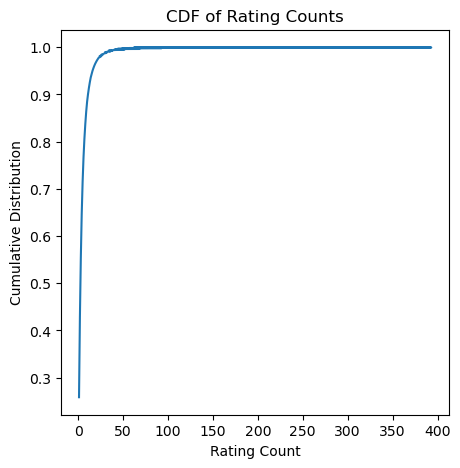

New Threshold to Retain More Data: 6.0


In [65]:
# Calculate cumulative distribution
cumulative_distribution = counts_value_counts.cumsum() / counts_value_counts.sum()

# Plot CDF
plt.figure(figsize=[5,5])
plt.plot(counts_value_counts.index, cumulative_distribution)
plt.xlabel('Rating Count')
plt.ylabel('Cumulative Distribution')
plt.title('CDF of Rating Counts')
plt.show()

# Determine threshold based on desired percentile
desired_percentile = 0.75
threshold = cumulative_distribution[cumulative_distribution >= desired_percentile].index[0]

print("New Threshold to Retain More Data:", threshold)

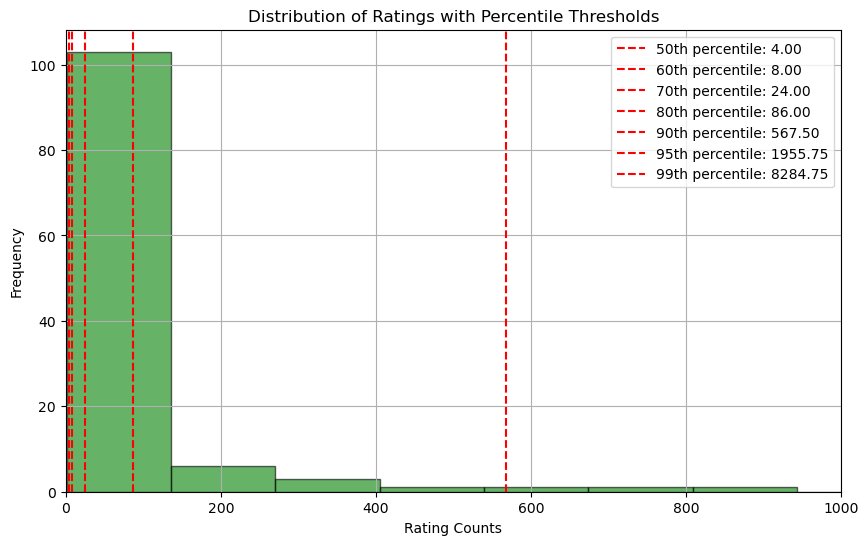

In [66]:
# Calculate thresholds for different percentiles
percentiles = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
thresholds = {p: np.percentile(counts_value_counts, p*100) for p in percentiles}

# Visualize the distribution and mark percentile thresholds
plt.figure(figsize=(10, 6))
plt.hist(counts_value_counts, bins=100, alpha=0.6, color='g', edgecolor='black')

for p, threshold in thresholds.items():
    plt.axvline(threshold, color='r', linestyle='--', label=f'{int(p*100)}th percentile: {threshold:.2f}')

plt.title('Distribution of Ratings with Percentile Thresholds')
plt.xlabel('Rating Counts')
plt.ylabel('Frequency')
plt.xlim(0,1000)
plt.legend()
plt.grid(True)
plt.show()

In [103]:
#Through the computation of the CDF and understanding the percentiles of the data, I chose a minimum threshold of 7 rating count.

In [68]:
rmpStats = rmpStats[rmpStats['Count'] > 7]
rmpStats = rmpStats.reset_index(drop=True)

rmpStats.shape

(10108, 32)

In [69]:
rmpStats.head()

,Avg Rating,Avg Difficulty,Count,Pepper,Online Count,Male,Female,Major,University,State,...,Hilarious,Test heavy,Graded by few things,Amazing lectures,Caring,Extra credit,Group projects,Lecture heavy,Weighted Avg Rating,Weighted Avg Difficulty
0,3.5,3.3,22.0,0.0,7.0,1,0,English,Eastern Florida State College,FL,...,0.056604,0.0,0.0,0.000000,0.056604,0.000000,0.018868,0.056604,3.5,3.3
1,2.6,4.1,10.0,0.0,0.0,1,0,Management,University of Alabama,AL,...,0.000000,0.0,0.0,0.052632,0.052632,0.000000,0.263158,0.052632,2.6,4.1
2,4.3,3.3,16.0,1.0,0.0,0,1,English,Concordia University,QC,...,0.023810,0.0,0.0,0.047619,0.238095,0.000000,0.000000,0.023810,4.3,3.3
3,4.1,1.8,8.0,0.0,0.0,0,1,Education,Mount Royal University,AB,...,0.000000,0.0,0.0,0.000000,0.166667,0.000000,0.000000,0.000000,4.1,1.8
4,3.5,3.2,20.0,1.0,0.0,1,0,Business,Benedictine University,IL,...,0.000000,0.0,0.0,0.000000,0.161290,0.193548,0.000000,0.129032,3.5,3.2


In [70]:
rmpStats.head()

,Avg Rating,Avg Difficulty,Count,Pepper,Online Count,Male,Female,Major,University,State,...,Hilarious,Test heavy,Graded by few things,Amazing lectures,Caring,Extra credit,Group projects,Lecture heavy,Weighted Avg Rating,Weighted Avg Difficulty
0,3.5,3.3,22.0,0.0,7.0,1,0,English,Eastern Florida State College,FL,...,0.056604,0.0,0.0,0.000000,0.056604,0.000000,0.018868,0.056604,3.5,3.3
1,2.6,4.1,10.0,0.0,0.0,1,0,Management,University of Alabama,AL,...,0.000000,0.0,0.0,0.052632,0.052632,0.000000,0.263158,0.052632,2.6,4.1
2,4.3,3.3,16.0,1.0,0.0,0,1,English,Concordia University,QC,...,0.023810,0.0,0.0,0.047619,0.238095,0.000000,0.000000,0.023810,4.3,3.3
3,4.1,1.8,8.0,0.0,0.0,0,1,Education,Mount Royal University,AB,...,0.000000,0.0,0.0,0.000000,0.166667,0.000000,0.000000,0.000000,4.1,1.8
4,3.5,3.2,20.0,1.0,0.0,1,0,Business,Benedictine University,IL,...,0.000000,0.0,0.0,0.000000,0.161290,0.193548,0.000000,0.129032,3.5,3.2


In [71]:
rmpStats = rmpStats.drop('Weighted Avg Rating', axis=1)
rmpStats = rmpStats.drop('Weighted Avg Difficulty', axis=1)

# Questions

## #1

In [72]:
#The data does not have large-interindivudal variability. This is because when examine the charts, mean, and SD, that they
#are roughly very similar.

In [73]:
#Just be extra sure and receive a statistical number, it is proven through Leven's statistical test (Should find a source
# that shows how this is useful. that the variances are similar)

In [74]:
#Therefore a statistical test such as an indepdendent t-test would work perfectly here.

In [75]:
print(male_ratings.shape)
print(female_ratings.shape)

(27163,)
(24926,)


In [76]:
# Calculate mean and standard deviation of ratings by gender
q1_df = rmpStats
male_ratings = q1_df[q1_df['Male'] == 1]['Avg Rating']
female_ratings = q1_df[q1_df['Female'] == 1]['Avg Rating']

print("Male Ratings - Mean:", male_ratings.mean(), "Std Dev:", male_ratings.std())
print("Female Ratings - Mean:", female_ratings.mean(), "Std Dev:", female_ratings.std())

Male Ratings - Mean: 3.9546726457399104 Std Dev: 0.8677406104692201
Female Ratings - Mean: 3.878645488638871 Std Dev: 0.9126444418076796


In [77]:
# Perform t-test
t_stat, p_value = ttest_ind(male_ratings, female_ratings, equal_var=False)
print("T-Statistic:", t_stat, "P-Value:", p_value)
#High t-value, signifigant

T-Statistic: 4.257982539464652 P-Value: 2.0826898508398875e-05


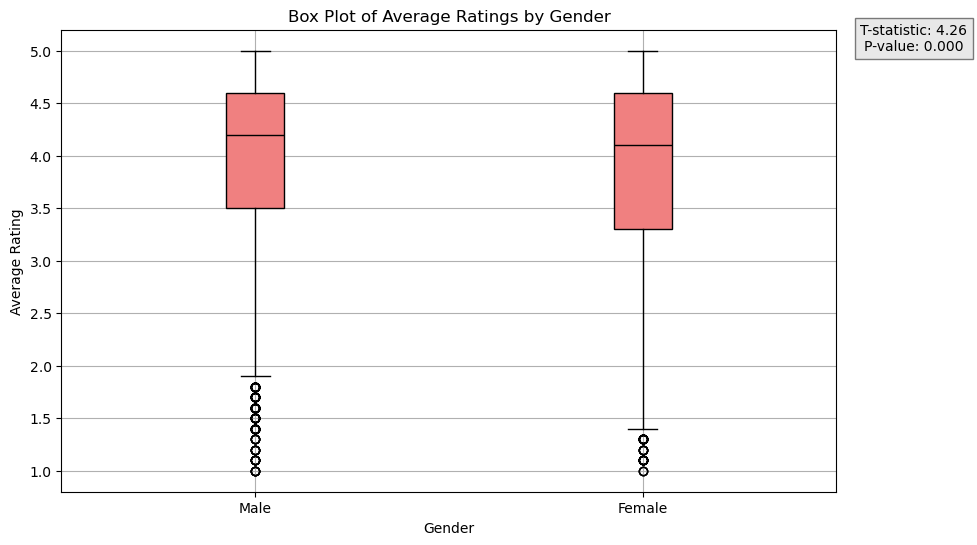

In [78]:
# Create a boxplot using matplotlib
plt.figure(figsize=(10, 6))
plt.boxplot([male_ratings,female_ratings], labels=['Male', 'Female'], patch_artist=True,
            boxprops=dict(facecolor='lightcoral', color='black'),
            medianprops=dict(color='black'))

plt.title('Box Plot of Average Ratings by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Rating')
plt.grid(True)

# Annotate with t-test results
plt.text(2.7,max(max(male_ratings),max(female_ratings)),f'T-statistic: {t_stat:.2f}\nP-value: {p_value:.3f}',
         horizontalalignment='center', fontsize=10,
         bbox=dict(facecolor='lightgrey', alpha=0.5))

plt.show()

In [79]:
q1_df['Online Count'].head(30)

0      7.0
1      0.0
2      0.0
3      0.0
4      0.0
5      1.0
6      0.0
7      1.0
8      8.0
9      2.0
10     0.0
11     0.0
12     0.0
13     0.0
14     0.0
15     0.0
16     1.0
17     5.0
18     0.0
19     0.0
20     0.0
21     4.0
22     0.0
23     0.0
24     0.0
25     0.0
26    14.0
27     0.0
28     0.0
29     1.0
Name: Online Count, dtype: float64

## #2

Variance for Male Professors: 0.7529737670574947
Variance for Female Professors: 0.8329198771624511
Levene's Test Statistic: 17.73330395596457, p-value: 2.5634080908712478e-05


C:\Users\theel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\theel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


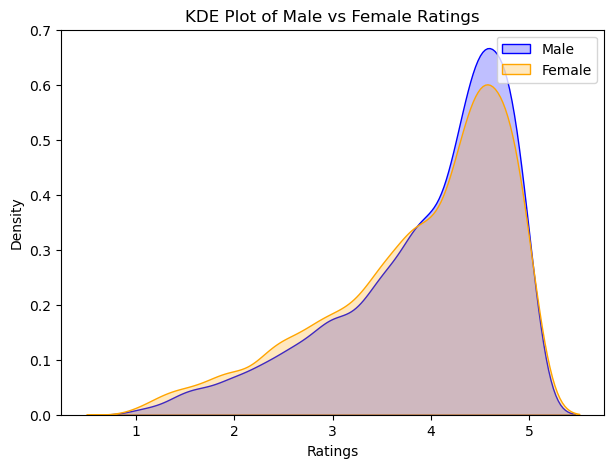

In [102]:


# Visualization: Boxplot of ratings by gender
#plt.figure(figsize=(10, 6))
#plt.boxplot([male_ratings.dropna(), female_ratings.dropna()], labels=['Male', 'Female'])
#plt.title('Distribution of Ratings by Gender')
#plt.ylabel('Average Rating')
#plt.xlabel('Gender')
#plt.grid(axis='y')
#plt.show()
import seaborn as sns
male_variance = np.var(male_ratings, ddof=1)
female_variance = np.var(female_ratings, ddof=1)

# Perform Levene's test for equality of variances
levene_stat, p_value = levene(male_ratings.dropna(), female_ratings.dropna())

print(f"Variance for Male Professors: {male_variance}")
print(f"Variance for Female Professors: {female_variance}")
print(f"Levene's Test Statistic: {levene_stat}, p-value: {p_value}")

plt.figure(figsize=(7,5))
sns.kdeplot(male_ratings, fill=True, label='Male', color='blue')
sns.kdeplot(female_ratings, fill=True, label='Female', color='orange')

plt.xlabel('Ratings')
plt.ylabel('Density')
plt.title('KDE Plot of Male vs Female Ratings')
plt.legend()
plt.show()

## #3

In [81]:
#Just calculate cohens D
#cohens d
mean_male = male_ratings.mean()
std_male = male_ratings.std()
mean_female = female_ratings.mean()
std_female = female_ratings.std()
n_male = male_ratings.count()
n_female = female_ratings.count()

# Calculate Cohen's d
mean_diff = mean_female - mean_male
pooled_std = (((n_male - 1) * std_male ** 2 + (n_female - 1) * std_female ** 2) / (n_male + n_female - 2)) ** 0.5
cohens_d = mean_diff / pooled_std

# Calculate standard error for Cohen's d
se_d = np.sqrt((n_male + n_female) / (n_male * n_female) + (cohens_d**2 / (2 * (n_male + n_female))))

# Calculate 95% confidence interval
ci_lower_avg = cohens_d - 1.96 * se_d
ci_upper_avg = cohens_d + 1.96 * se_d

print(f"95% CI for Cohen's d (Average Rating): [{ci_lower_avg:.4f}, {ci_upper_avg:.4f}]")

# Calculate variances
male_variance = male_ratings.var()
female_variance = female_ratings.var()

# Calculate pooled variance
pooled_variance = ((n_male - 1) * male_variance + (n_female - 1) * female_variance) / (n_male + n_female - 2)

# Calculate Cohen's d for variance difference
cohens_d_variance = (male_variance - female_variance) / np.sqrt(pooled_variance)

# Calculate standard error for Cohen's d_v
se_dv = np.sqrt((n_male + n_female) / (n_male * n_female) + (cohens_d_variance**2 / (2 * (n_male + n_female))))

# Calculate 95% confidence interval
ci_lower_var = cohens_d_variance - 1.96 * se_dv
ci_upper_var = cohens_d_variance + 1.96 * se_dv

print(f"95% CI for Cohen's d (Variance Difference): [{ci_lower_var:.4f}, {ci_upper_var:.4f}]")

95% CI for Cohen's d (Average Rating): [-0.1248, -0.0464]
95% CI for Cohen's d (Variance Difference): [-0.1292, -0.0508]


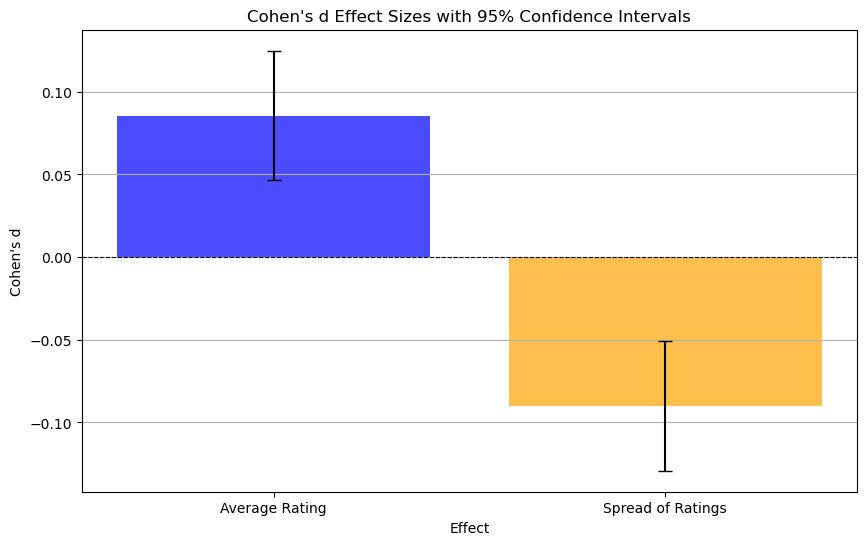

Cohen's d for Average Rating: 0.0856 (95% CI: [0.0464, 0.1248])
Cohen's d for Spread of Ratings: -0.0900 (95% CI: [-0.1292, -0.0508])


In [82]:
# Calculate pooled standard deviation for Cohen's d (average rating)
pooled_std_avg_rating = np.sqrt(((n_male - 1) * std_male**2 + (n_female - 1) * std_female**2) / (n_male + n_female - 2))
cohens_d_avg_rating = (mean_male - mean_female) / pooled_std_avg_rating

# Calculate standard error and 95% CI for Cohen's d (average rating)
se_avg_rating = np.sqrt((n_male + n_female) / (n_male * n_female) + (cohens_d_avg_rating**2 / (2 * (n_male + n_female))))
ci_lower_avg_rating = cohens_d_avg_rating - 1.96 * se_avg_rating
ci_upper_avg_rating = cohens_d_avg_rating + 1.96 * se_avg_rating

# Calculate variances for spread of ratings
var_male = male_ratings.var()
var_female = female_ratings.var()

# Calculate pooled variance and Cohen's d for variance difference
pooled_variance_spread = ((n_male - 1) * var_male + (n_female - 1) * var_female) / (n_male + n_female - 2)
cohens_d_spread = (var_male - var_female) / np.sqrt(pooled_variance_spread)

# Calculate standard error and 95% CI for Cohen's d (spread of ratings)
se_spread = np.sqrt((n_male + n_female) / (n_male * n_female) + (cohens_d_spread**2 / (2 * (n_male + n_female))))
ci_lower_spread = cohens_d_spread - 1.96 * se_spread
ci_upper_spread = cohens_d_spread + 1.96 * se_spread

# Create a bar chart for Cohen's d with confidence intervals
effect_sizes = [cohens_d_avg_rating, cohens_d_spread]
ci_lowers = [ci_lower_avg_rating, ci_lower_spread]
ci_uppers = [ci_upper_avg_rating, ci_upper_spread]
labels = ['Average Rating', 'Spread of Ratings']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, effect_sizes, color=['blue', 'orange'], alpha=0.7,
               yerr=[(es - cl, cu - es) for es, cl, cu in zip(effect_sizes, ci_lowers, ci_uppers)], capsize=5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Cohen's d Effect Sizes with 95% Confidence Intervals")
plt.ylabel("Cohen's d")
plt.xlabel("Effect")
plt.grid(axis='y')
plt.show()

# Print results summary
print(f"Cohen's d for Average Rating: {cohens_d_avg_rating:.4f} (95% CI: [{ci_lower_avg_rating:.4f}, {ci_upper_avg_rating:.4f}])")
print(f"Cohen's d for Spread of Ratings: {cohens_d_spread:.4f} (95% CI: [{ci_lower_spread:.4f}, {ci_upper_spread:.4f}])")

In [83]:
#The low effect size of cohen's d suggests that this is not practically meaningful. As we dive into the visualization of the
# data, we can see that they are extremely similar in their ratings. The likely reason why this was statistically significant
# could be due to the large sample size of over 20000 for both genders, and the 

## #4

Most Gendered Tags:
                 Tag  T-Statistic        P-Value  Cohen's d  Adjusted P-Value
12         Hilarious    22.041063  3.523092e-105   0.428415     7.046185e-104
15  Amazing lectures    11.813091   5.431366e-32   0.232792      1.086273e-30
2          Respected    10.683282   1.692215e-26   0.211142      3.384430e-25

Least Gendered Tags:
                Tag  T-Statistic   P-Value  Cohen's d  Adjusted P-Value
6  Lots of homework    -3.082373  0.002059  -0.061693          0.041187
0      Tough grader    -2.787295  0.005326  -0.056031          0.106512
8      Pop quizzes!     0.909992  0.362849   0.018101          1.000000


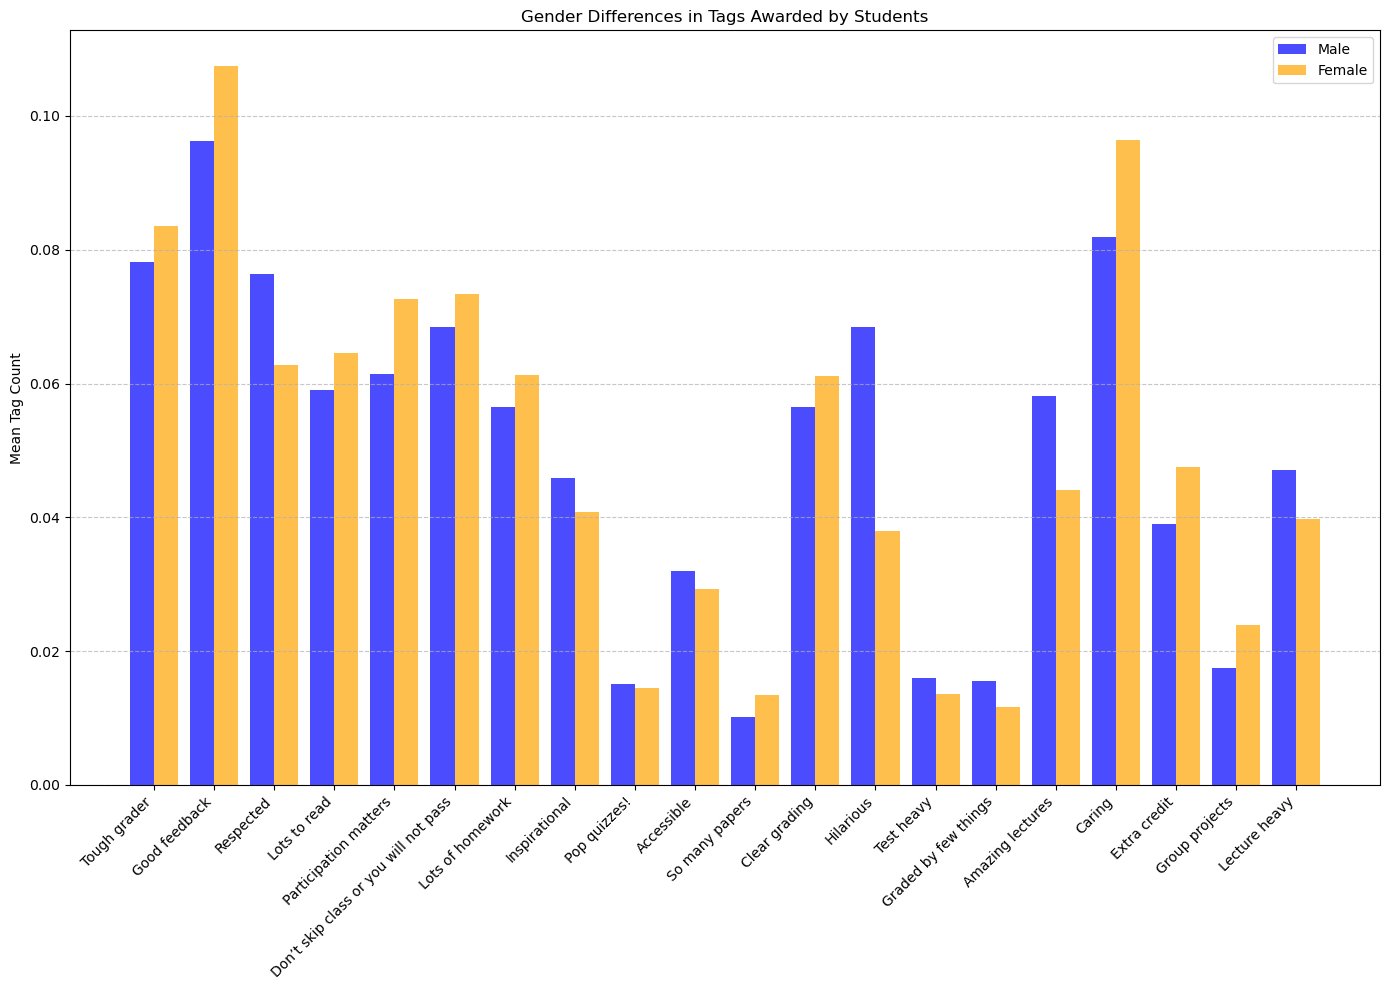

In [84]:
# Initialize results storage
results = []
mean_male_tags = []
mean_female_tags = []

# Loop through each tag (columns 1–20)
for i in range(20):
    tag_name = tags_data.columns[i]
    
    # Separate tag counts by gender
    male_tags = q1_df[q1_df['Male'] == 1][tag_name].dropna()
    female_tags = q1_df[q1_df['Female'] == 1][tag_name].dropna()
    
    # Perform t-test
    t_stat, p_value = ttest_ind(male_tags, female_tags, equal_var=False)
    
    # Calculate means and pooled standard deviation for Cohen's d
    mean_male = male_tags.mean()
    mean_female = female_tags.mean()
    std_male = male_tags.std()
    std_female = female_tags.std()
    
    pooled_std = np.sqrt(((len(male_tags) - 1) * std_male**2 + (len(female_tags) - 1) * std_female**2) / 
                         (len(male_tags) + len(female_tags) - 2))
    cohens_d = (mean_male - mean_female) / pooled_std
    
    # Store results
    results.append({'Tag': tag_name, 'T-Statistic': t_stat, 'P-Value': p_value, 'Cohen\'s d': cohens_d})
    
    # Store means for visualization
    mean_male_tags.append(mean_male)
    mean_female_tags.append(mean_female)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Adjust p-values for multiple comparisons (Bonferroni correction)
results_df['Adjusted P-Value'] = multipletests(results_df['P-Value'], method='bonferroni')[1]

# Sort by adjusted p-value
results_df = results_df.sort_values(by='Adjusted P-Value')

# Identify most and least gendered tags
most_gendered = results_df.head(3)
least_gendered = results_df.tail(3)

# Output results for most and least gendered tags
print("Most Gendered Tags:")
print(most_gendered)
print("\nLeast Gendered Tags:")
print(least_gendered)

# Visualization: Bar chart for mean tag counts by gender
x_labels = tags_data.columns[:20]
x = np.arange(len(x_labels))  # Tag indices

plt.figure(figsize=(14, 10))
bar_width = 0.4

# Plot male and female means side-by-side
plt.bar(x - bar_width/2, mean_male_tags, bar_width, label='Male', color='blue', alpha=0.7)
plt.bar(x + bar_width/2, mean_female_tags, bar_width, label='Female', color='orange', alpha=0.7)

# Add labels and title
plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel('Mean Tag Count')
plt.title('Gender Differences in Tags Awarded by Students')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## #5

In [85]:
# Separate difficulty ratings by gender
difficulty_male = q1_df[q1_df['Male'] == 1]['Avg Difficulty']
difficulty_female = q1_df[q1_df['Female'] == 1]['Avg Difficulty']

# Perform t-test
t_stat, p_value = ttest_ind(difficulty_male.dropna(), difficulty_female.dropna(), equal_var=False)

# Calculate means for context
mean_difficulty_male = difficulty_male.mean()
mean_difficulty_female = difficulty_female.mean()

# Print results
print(f"Mean Difficulty (Male): {mean_difficulty_male:.4f}")
print(f"Mean Difficulty (Female): {mean_difficulty_female:.4f}")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Interpret results
if p_value < 0.05:
    print("The difference in average difficulty between male and female professors is statistically significant.")
else:
    print("There is no statistically significant difference in average difficulty between male and female professors.")

Mean Difficulty (Male): 2.9295
Mean Difficulty (Female): 2.9225
T-Statistic: 0.4456
P-Value: 0.6559
There is no statistically significant difference in average difficulty between male and female professors.


Mean Difficulty (Male): 2.9295
Mean Difficulty (Female): 2.9225
T-Statistic: 0.4456
P-Value: 0.6559
There is no statistically significant difference in average difficulty between male and female professors.


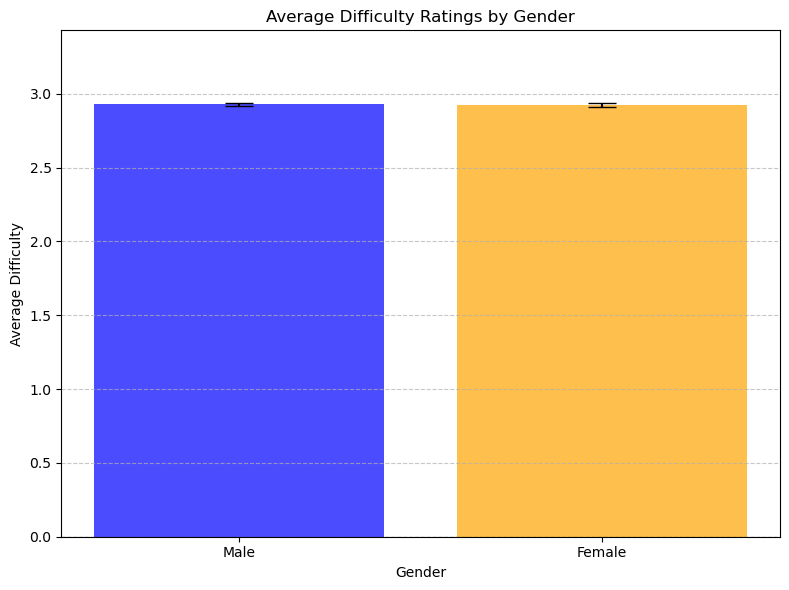

In [86]:
# Separate difficulty ratings by gender
difficulty_male = q1_df[q1_df['Male'] == 1]['Avg Difficulty']
difficulty_female = q1_df[q1_df['Female'] == 1]['Avg Difficulty']

# Perform t-test
t_stat, p_value = ttest_ind(difficulty_male.dropna(), difficulty_female.dropna(), equal_var=False)

# Calculate means and standard errors for visualization
mean_difficulty_male = difficulty_male.mean()
mean_difficulty_female = difficulty_female.mean()
sem_difficulty_male = difficulty_male.sem()  # Standard error of the mean
sem_difficulty_female = difficulty_female.sem()

# Print results
print(f"Mean Difficulty (Male): {mean_difficulty_male:.4f}")
print(f"Mean Difficulty (Female): {mean_difficulty_female:.4f}")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

if p_value < 0.05:
    print("The difference in average difficulty between male and female professors is statistically significant.")
else:
    print("There is no statistically significant difference in average difficulty between male and female professors.")

# Visualization: Bar chart for average difficulty by gender
labels = ['Male', 'Female']
means = [mean_difficulty_male, mean_difficulty_female]
errors = [sem_difficulty_male, sem_difficulty_female]

plt.figure(figsize=(8, 6))
plt.bar(labels, means, yerr=errors, capsize=10, color=['blue', 'orange'], alpha=0.7)
plt.title('Average Difficulty Ratings by Gender')
plt.ylabel('Average Difficulty')
plt.xlabel('Gender')
plt.ylim(0, max(means) + 0.5)  # Adjust y-axis limit for better visualization
plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--')  # Baseline
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight significance if applicable
if p_value < 0.005:
    plt.text(0.5, max(means) + 0.2, '* Significant Difference', ha='center', color='red', fontsize=12)

plt.tight_layout()
plt.show()

## #6

Cohen's d: 0.0089
95% Confidence Interval: [-0.0303, 0.0481]


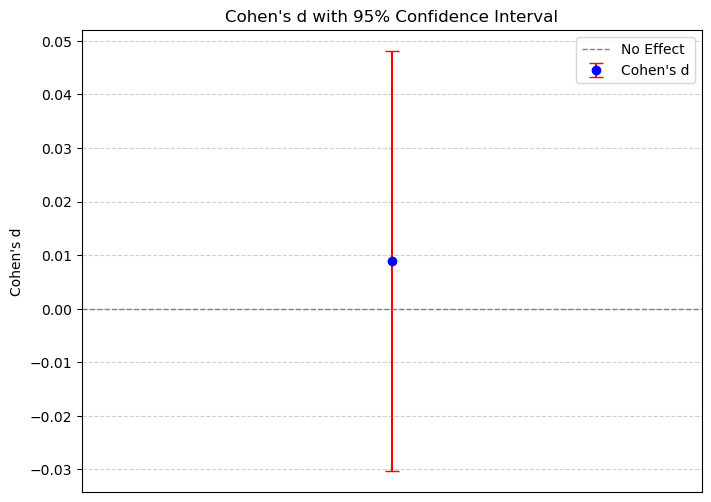

In [97]:
# Given values (replace these with actual values from your dataset)
mean_male = difficulty_male.mean()
mean_female = difficulty_female.mean()
std_male = difficulty_male.std()
std_female = difficulty_female.std()
n_male = difficulty_male.count()
n_female = difficulty_female.count() 

# Calculate pooled standard deviation
pooled_std = np.sqrt(((n_male - 1) * std_male**2 + (n_female - 1) * std_female**2) / (n_male + n_female - 2))

# Calculate Cohen's d
cohens_d = (mean_male - mean_female) / pooled_std

# Calculate standard error of Cohen's d
se_d = np.sqrt((n_male + n_female) / (n_male * n_female) + (cohens_d**2 / (2 * (n_male + n_female))))

# Calculate 95% confidence interval
ci_lower = cohens_d - 1.96 * se_d
ci_upper = cohens_d + 1.96 * se_d

# Print results
print(f"Cohen's d: {cohens_d:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Ensure positive yerr values
yerr = np.array([[cohens_d - ci_lower], [ci_upper - cohens_d]])

# Plot Cohen's d and its confidence interval
plt.figure(figsize=(8, 6))
plt.errorbar(
    x=0, 
    y=cohens_d, 
    yerr=yerr, 
    fmt='o', 
    color='blue', 
    ecolor='red', 
    capsize=5, 
    label="Cohen's d"
)
plt.axhline(0, color='gray', linestyle='--', linewidth=1, label='No Effect')  # Line for no effect
plt.title("Cohen's d with 95% Confidence Interval")
plt.ylabel("Cohen's d")
plt.xticks([])  # Remove x-axis ticks since there's only one point
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## #7

In [88]:
num_data = num_data.drop('Retake', axis=1)

In [89]:
# Define target variable (Average Rating) and predictors (all other numerical columns)
target = 'Avg Rating'
predictors = [col for col in num_data.columns if col != target]

# Drop non-numerical or irrelevant columns if necessary (e.g., gender columns, booleans)
predictors = [col for col in predictors if q1_df[col].dtype in [np.float64, np.int64]]

# Check for missing values and handle them (drop rows with NaNs)
data = q1_df.dropna(subset=[target] + predictors)

# Address multicollinearity: Calculate VIF
X = data[predictors]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop features with high VIF (>10) to reduce multicollinearity
high_vif_features = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
X = X.drop(columns=high_vif_features)

# Update predictor list after removing high-VIF features
predictors = X.columns.tolist()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data[target], test_size=0.2, random_state=42)

# Build and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Identify most predictive factors (absolute value of coefficients)
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
most_predictive_factors = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

# Print results
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print("\nMost Predictive Factors:")
print(most_predictive_factors.head(10))

R²: 0.5371
RMSE: 0.6040

Most Predictive Factors:
          Feature  Coefficient  Abs_Coefficient
0  Avg Difficulty    -0.629596         0.629596
2          Pepper     0.605297         0.605297
4          Female    -0.083922         0.083922
3    Online Count    -0.005064         0.005064
1           Count     0.002279         0.002279


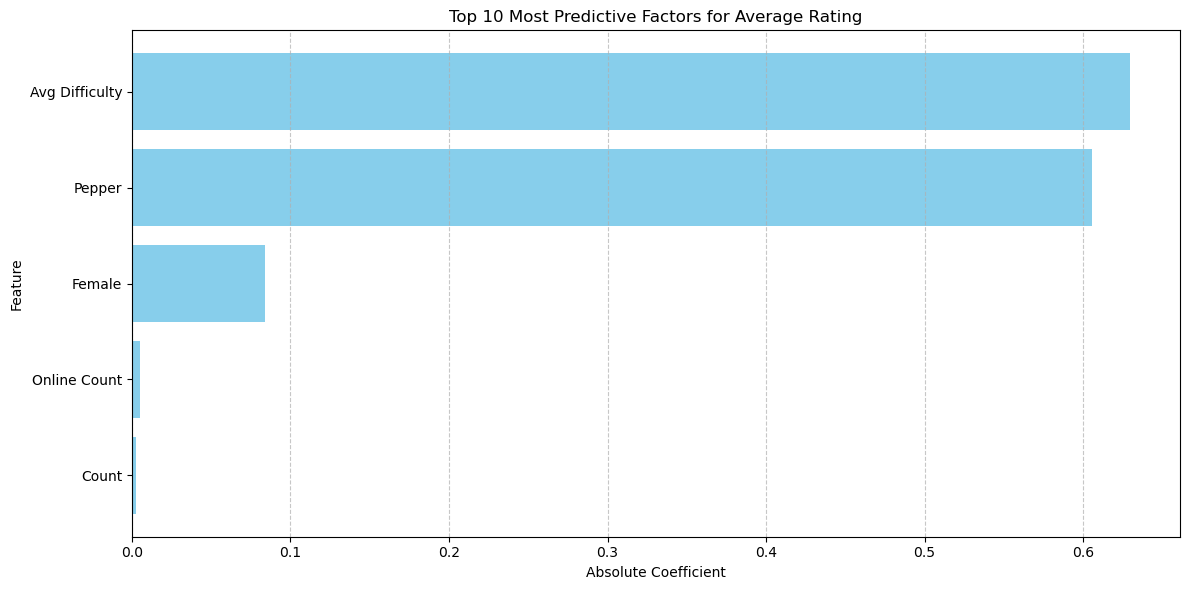

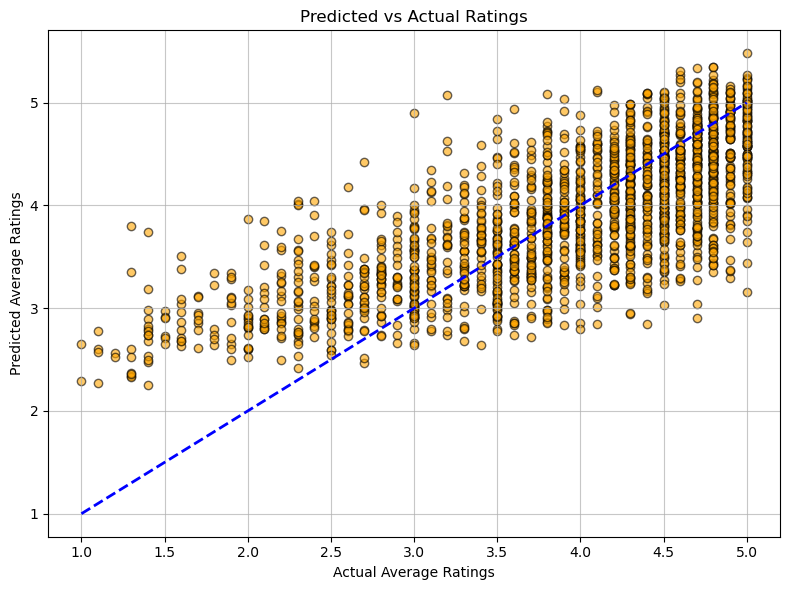

In [90]:
# Visualization 1: Feature Importance Plot (Top 10 Predictive Factors)
plt.figure(figsize=(12, 6))
top_features = most_predictive_factors.head(10)
plt.barh(top_features['Feature'], top_features['Abs_Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.title('Top 10 Most Predictive Factors for Average Rating')
plt.gca().invert_yaxis()  # Invert y-axis to show largest at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualization 2: Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='orange', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Actual Average Ratings')
plt.ylabel('Predicted Average Ratings')
plt.title('Predicted vs Actual Ratings')
plt.grid(alpha=0.7)
plt.tight_layout()
plt.show()

## #8

R²: 0.7696
RMSE: 0.4261

Most Predictive Tags:
                      Tag  Coefficient  Abs_Coefficient
15       Amazing lectures     3.911357         3.911357
1           Good feedback     3.595864         3.595864
2               Respected     3.252210         3.252210
11          Clear grading     2.902478         2.902478
16                 Caring     2.834236         2.834236
12              Hilarious     2.710581         2.710581
9              Accessible     2.465427         2.465427
7           Inspirational     2.305426         2.305426
17           Extra credit     2.189693         2.189693
4   Participation matters     1.826500         1.826500


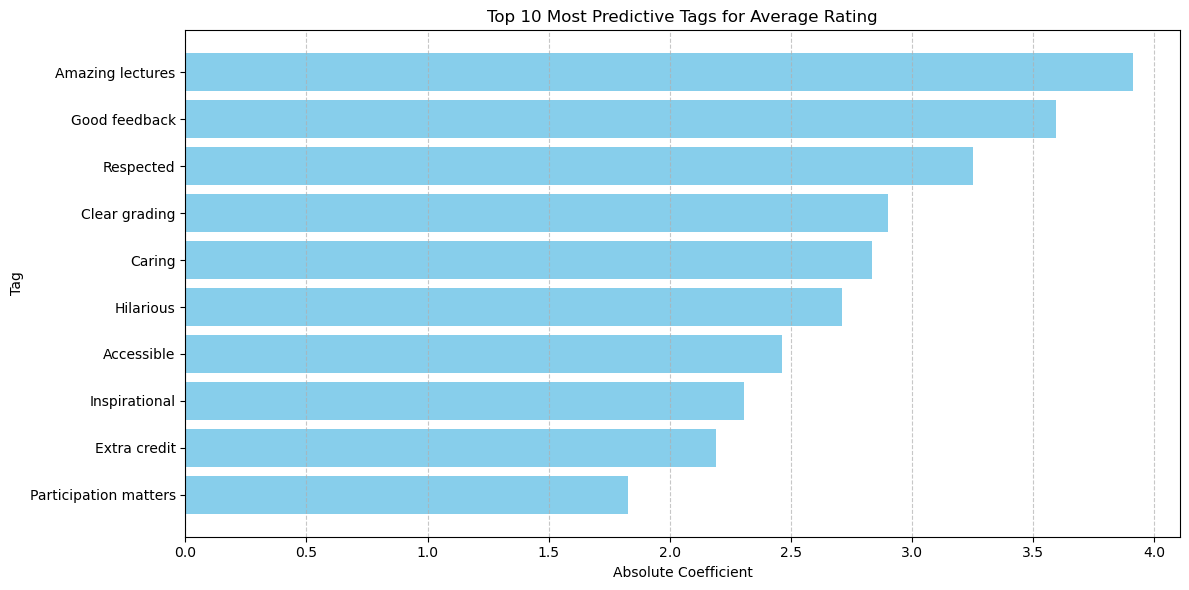

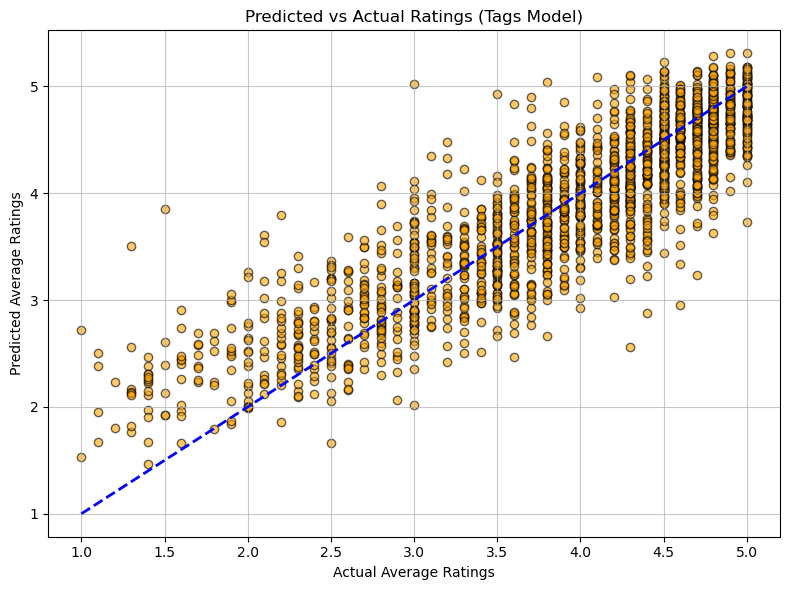

In [91]:
target = 'Avg Rating'
predictors = [col for col in tags_data.columns]

# Drop rows with missing values
data = q1_df.dropna(subset=[target] + predictors)

# Address multicollinearity: Calculate VIF
X = data[predictors]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop features with high VIF (>10)
high_vif_features = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
X = X.drop(columns=high_vif_features)

# Update predictor list after removing high-VIF features
predictors = X.columns.tolist()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data[target], test_size=0.2, random_state=42)

# Build and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Identify most predictive tags (absolute value of coefficients)
coefficients = pd.DataFrame({'Tag': X.columns, 'Coefficient': model.coef_})
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
most_predictive_tags = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

# Print results
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print("\nMost Predictive Tags:")
print(most_predictive_tags.head(10))

# Visualization 1: Feature Importance Plot (Top 10 Predictive Tags)
plt.figure(figsize=(12, 6))
top_tags = most_predictive_tags.head(10)
plt.barh(top_tags['Tag'], top_tags['Abs_Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Tag')
plt.title('Top 10 Most Predictive Tags for Average Rating')
plt.gca().invert_yaxis()  # Invert y-axis to show largest at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualization 2: Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='orange', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Actual Average Ratings')
plt.ylabel('Predicted Average Ratings')
plt.title('Predicted vs Actual Ratings (Tags Model)')
plt.grid(alpha=0.7)
plt.tight_layout()
plt.show()

## #9

R²: 0.6130
RMSE: 0.4903

Most Predictive Tags:
                     Tag  Coefficient  Abs_Coefficient
0           Tough grader     2.835244         2.835244
14  Graded by few things    -2.761628         2.761628
11         Clear grading    -2.616605         2.616605
13            Test heavy     2.596845         2.596845
17          Extra credit    -1.888916         1.888916
12             Hilarious    -1.839483         1.839483
16                Caring    -1.570784         1.570784
9             Accessible     1.469340         1.469340
2              Respected    -1.430363         1.430363
7          Inspirational    -1.374688         1.374688


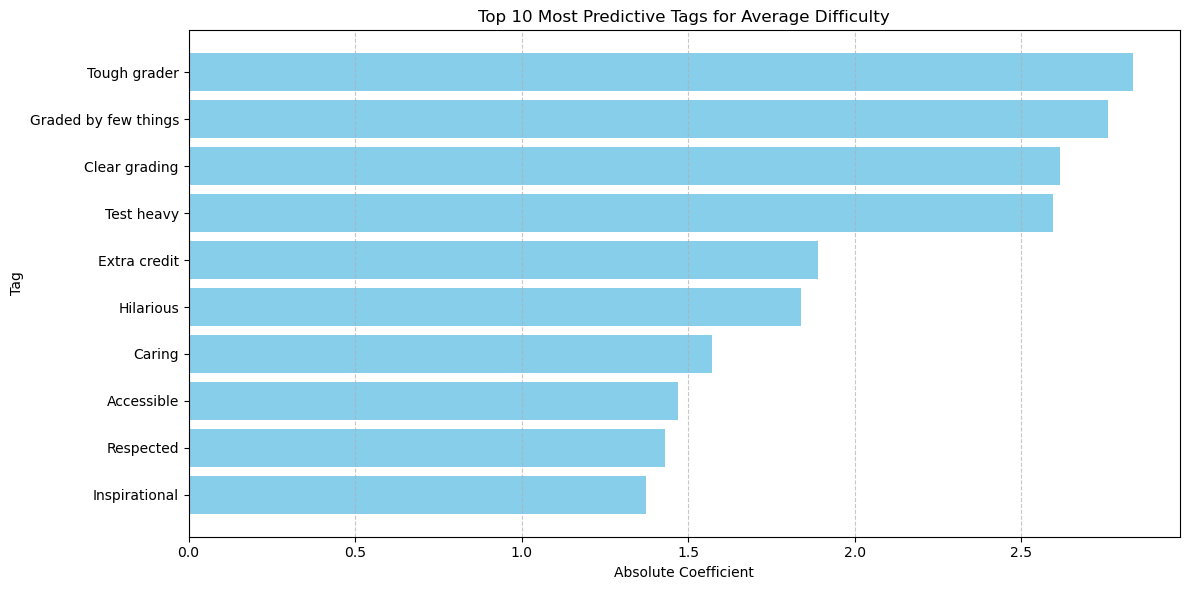

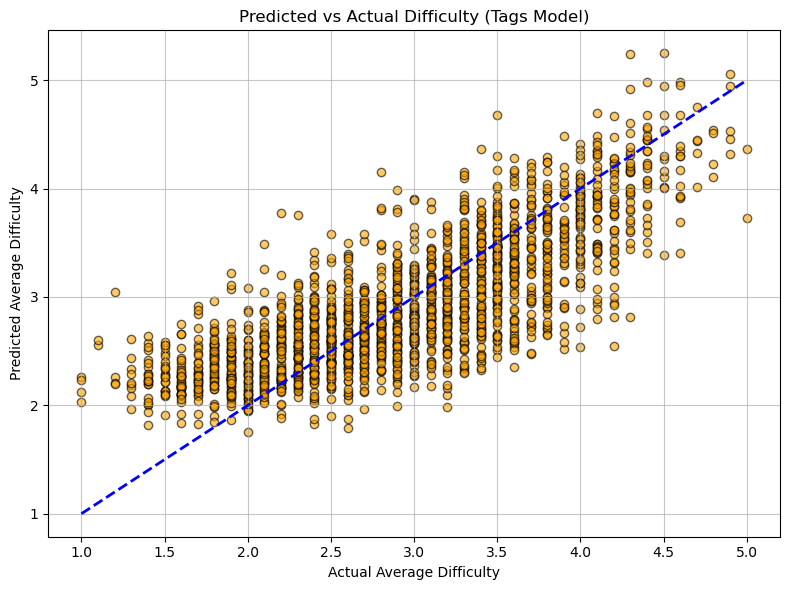

In [92]:
target = 'Avg Difficulty'
predictors = [col for col in tags_data.columns]

# Drop rows with missing values
data = q1_df.dropna(subset=[target] + predictors)

# Address multicollinearity: Calculate VIF
X = data[predictors]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop features with high VIF (>10)
high_vif_features = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
X = X.drop(columns=high_vif_features)

# Update predictor list after removing high-VIF features
predictors = X.columns.tolist()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data[target], test_size=0.2, random_state=42)

# Build and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Identify most predictive tags (absolute value of coefficients)
coefficients = pd.DataFrame({'Tag': X.columns, 'Coefficient': model.coef_})
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
most_predictive_tags = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

# Print results
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print("\nMost Predictive Tags:")
print(most_predictive_tags.head(10))

# Visualization 1: Feature Importance Plot (Top 10 Predictive Tags)
plt.figure(figsize=(12, 6))
top_tags = most_predictive_tags.head(10)
plt.barh(top_tags['Tag'], top_tags['Abs_Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Tag')
plt.title('Top 10 Most Predictive Tags for Average Difficulty')
plt.gca().invert_yaxis()  # Invert y-axis to show largest at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualization 2: Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='orange', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Actual Average Difficulty')
plt.ylabel('Predicted Average Difficulty')
plt.title('Predicted vs Actual Difficulty (Tags Model)')
plt.grid(alpha=0.7)
plt.tight_layout()
plt.show()

## #10

In [93]:
q1_df.columns

Index(['Avg Rating', 'Avg Difficulty', 'Count', 'Pepper', 'Online Count',
       'Male', 'Female', 'Major', 'University', 'State', 'Tough grader',
       'Good feedback', 'Respected', 'Lots to read', 'Participation matters',
       'Don’t skip class or you will not pass', 'Lots of homework',
       'Inspirational', 'Pop quizzes!', 'Accessible', 'So many papers',
       'Clear grading', 'Hilarious', 'Test heavy', 'Graded by few things',
       'Amazing lectures', 'Caring', 'Extra credit', 'Group projects',
       'Lecture heavy'],
      dtype='object')

AUROC: 0.8167

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.74      1058
         1.0       0.74      0.76      0.75      1075

    accuracy                           0.74      2133
   macro avg       0.74      0.74      0.74      2133
weighted avg       0.74      0.74      0.74      2133



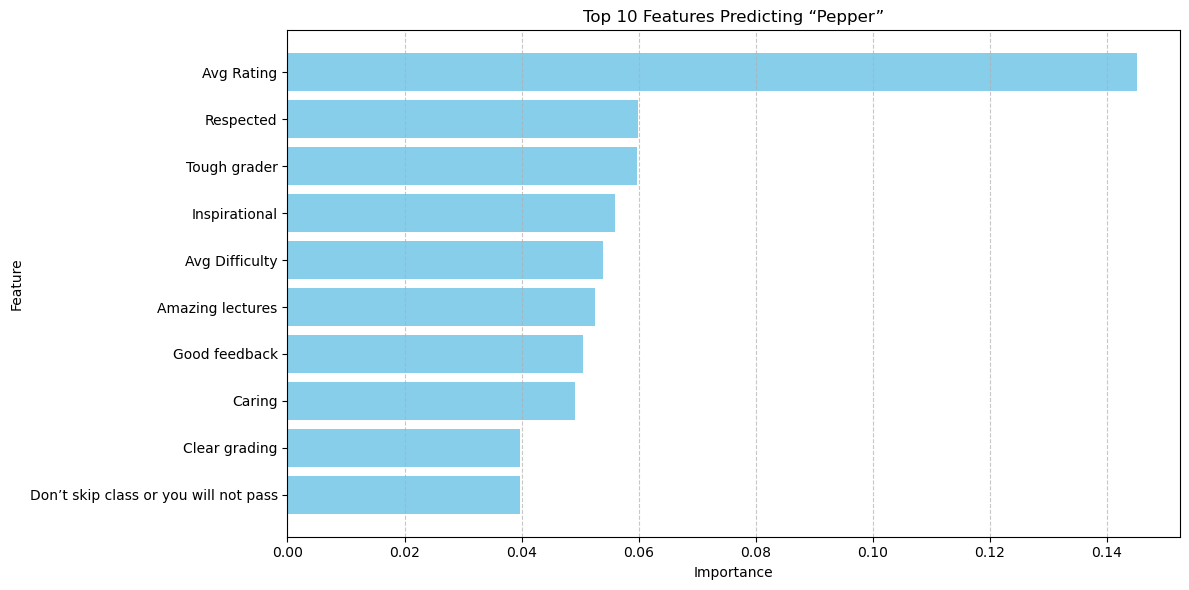

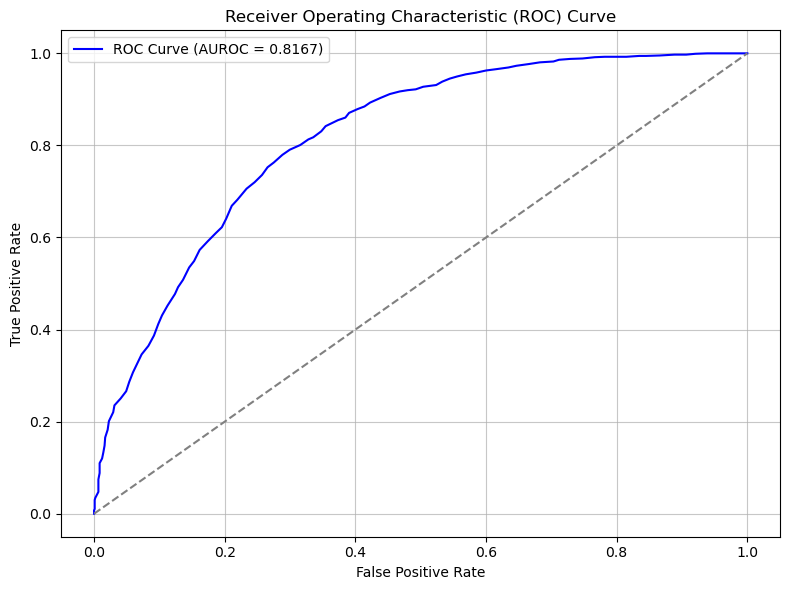

In [94]:
# Define target variable and predictors
target = 'Pepper'  # Binary target variable

# Ensure only numerical columns are included as predictors
predictors = [col for col in q1_df.columns if col != target and q1_df[col].dtype in [np.float64, np.int64]]

# Drop rows with missing values
data = q1_df.dropna(subset=[target] + predictors)

# Separate features (X) and target (y)
X = data[predictors]
y = data[target]

# Address class imbalance using SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Build a Random Forest Classifier with balanced class weights
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for AUROC

# Evaluate model performance
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUROC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Visualization 1: Feature Importance Plot (Top 10 Features)
plt.figure(figsize=(12, 6))
top_features = feature_importances.head(10)
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features Predicting “Pepper”')
plt.gca().invert_yaxis()  # Invert y-axis to show largest at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualization 2: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUROC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(alpha=0.7)
plt.tight_layout()
plt.show()

In [95]:
q1_df.dtypes

Avg Rating                               float64
Avg Difficulty                           float64
Count                                    float64
Pepper                                   float64
Online Count                             float64
Male                                       int64
Female                                     int64
Major                                     object
University                                object
State                                     object
Tough grader                             float64
Good feedback                            float64
Respected                                float64
Lots to read                             float64
Participation matters                    float64
Don’t skip class or you will not pass    float64
Lots of homework                         float64
Inspirational                            float64
Pop quizzes!                             float64
Accessible                               float64
So many papers      